# FECG Extraction -  sequential analysis method

>Paper: A robust fetal ECG detection method for abdominal recordings - Suzanna M M Martens et al 2007 Physiol. Meas. 28 373

# STEP 0: Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb

from modules import function, utils, qrsdetection
from modules.cleaning import baseline_wander_removal, powerline_interference_canceller, upsample_to_2kHz
from modules.qrsdetection import detect_mQRS, detect_fQRS
from modules.mecgcanceller import mecg_canceller
from modules.fecgextraction import FECG_avg
from modules.metrics import compute_metrics, compute_snr_sir_martens, calculate_paper_metrics


In [3]:
record = wfdb.rdrecord("./dataset/set-a/a04")
true_qrs = np.loadtxt("./dataset/set-a-text/a04.fqrs.txt")

X = record.p_signal
fs = record.fs
print(X.shape)

cmap = plt.cm.plasma
colors = [cmap(0.8), cmap(0.3),cmap(0.4),cmap(0.5)]  

(60000, 4)


# STEP 1: S1 → S2 — Baseline Wander Remover

The low-frequency baseline drift, caused by respiration and movement, is attenuated using a linear-phase high-pass FIR filter. A cut-off frequency of $3 \text{ Hz}$ is employed to minimize signal distortion while ensuring adequate removal of the drift component. The filter is applied in zero-phase mode to preserve the morphology of the FECG and MECG complexes.

In [4]:
S2 = baseline_wander_removal(X, fs)
print(S2.shape)

(60000, 4)


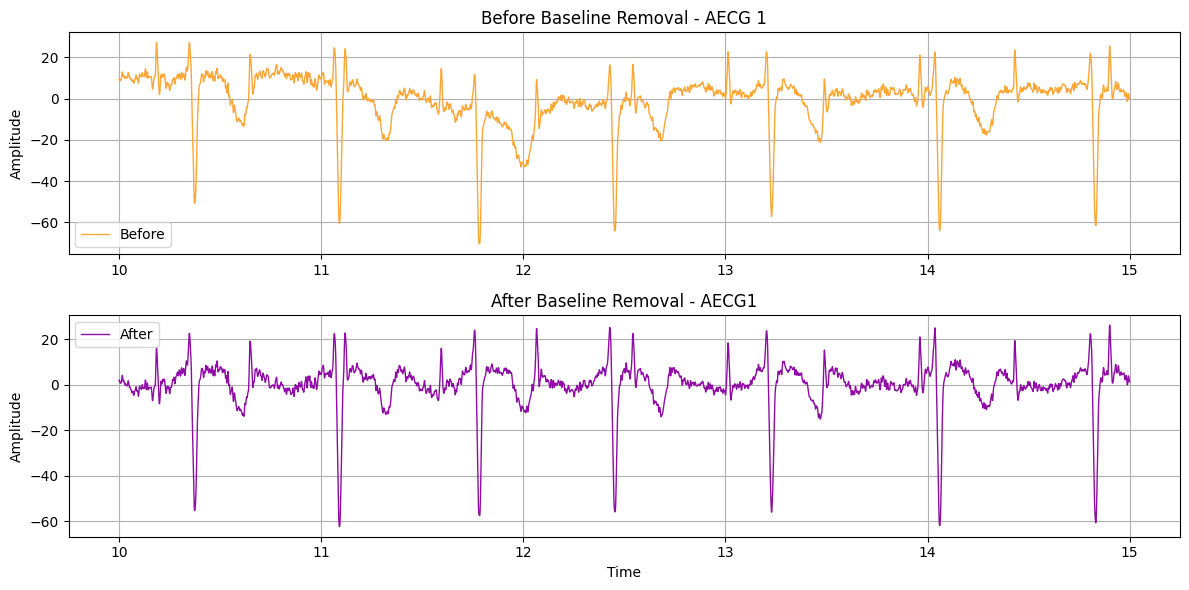

In [5]:
utils.plot_before_after(X,S2,fs, 'Baseline Removal')

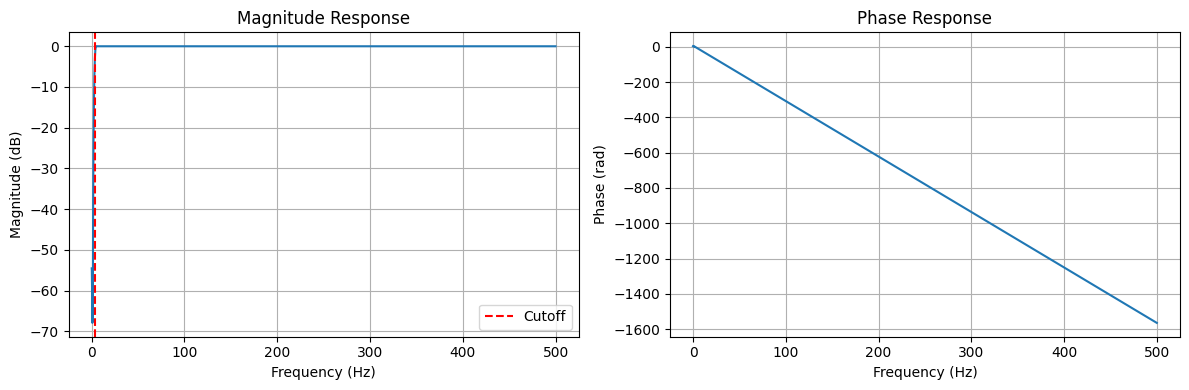

In [6]:
function.plot_fir_response(fs=fs, fc=3, numtaps=1001)


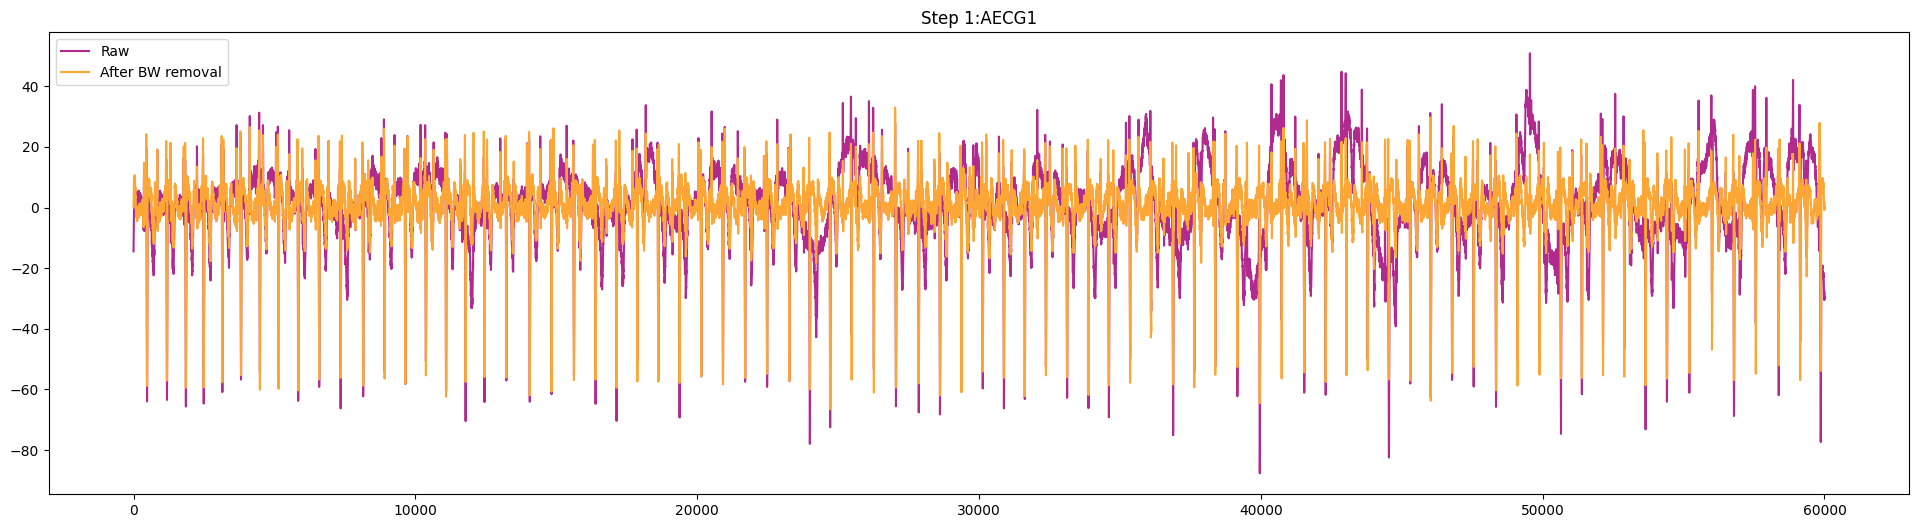

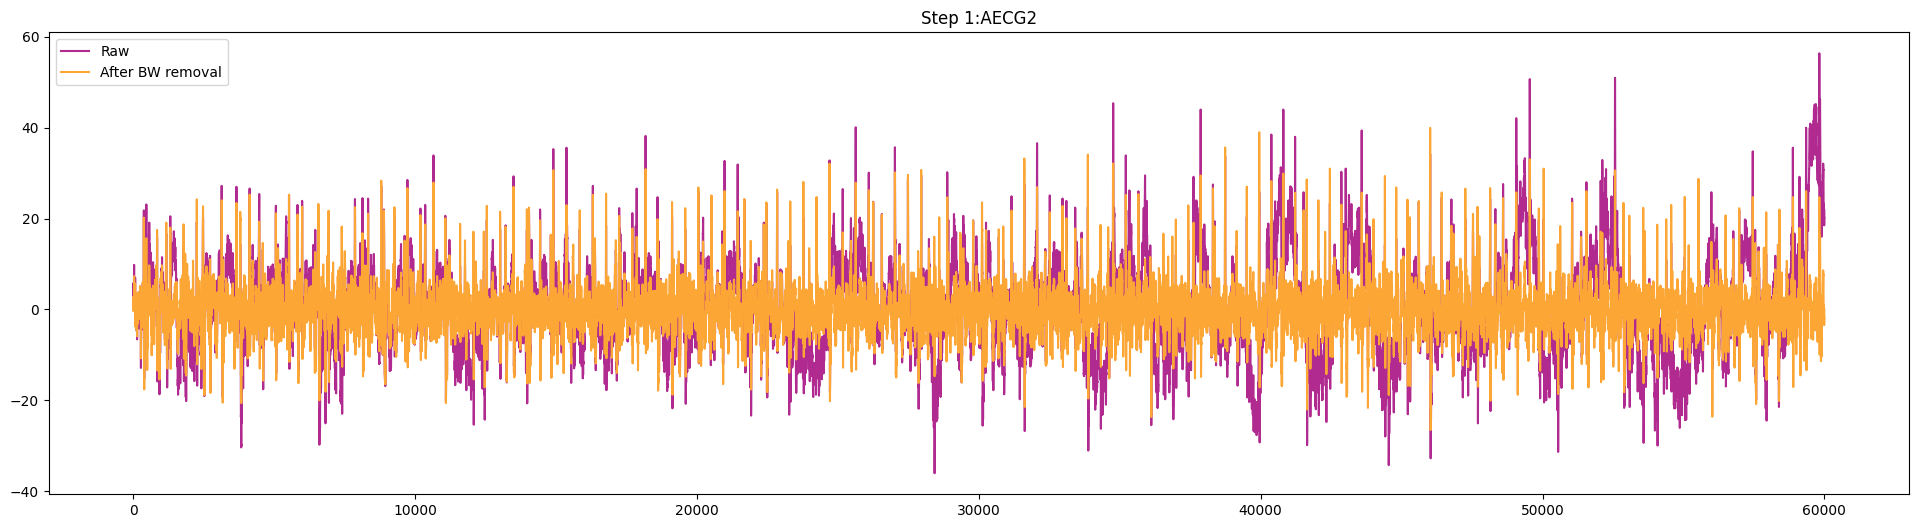

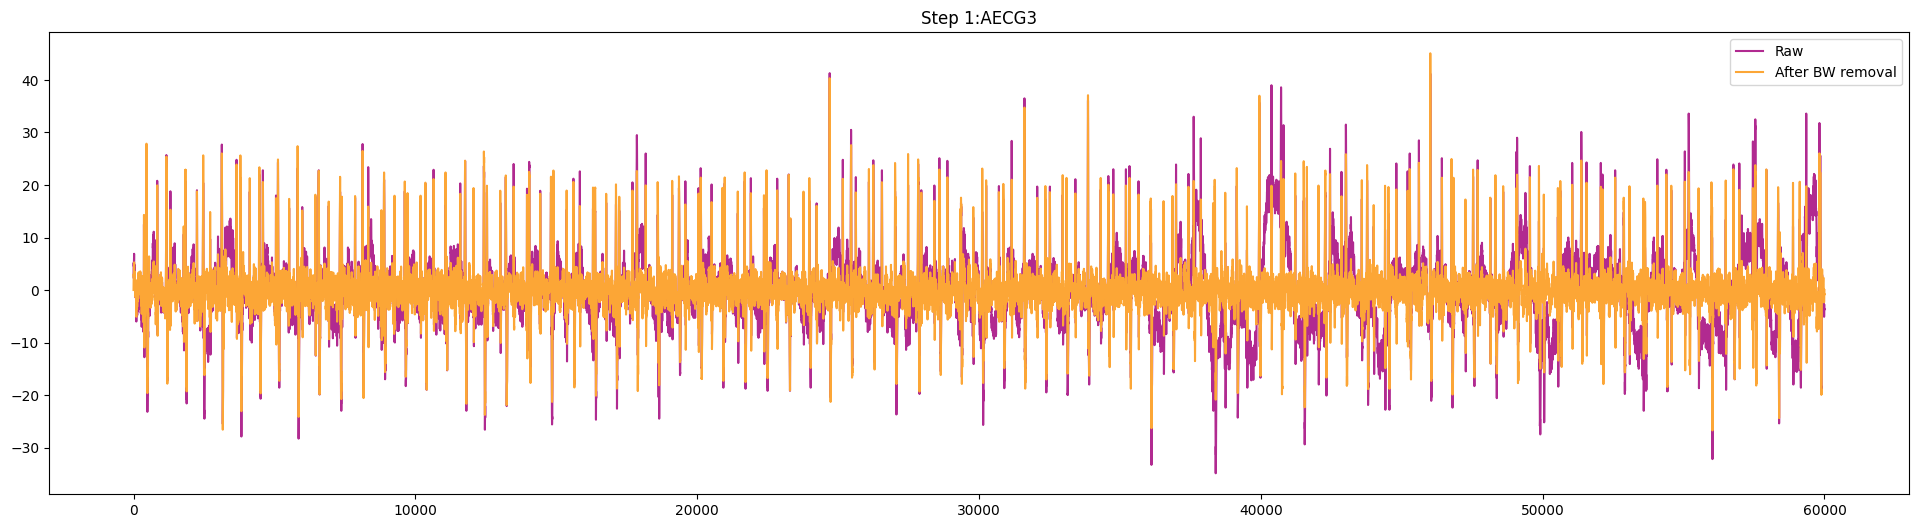

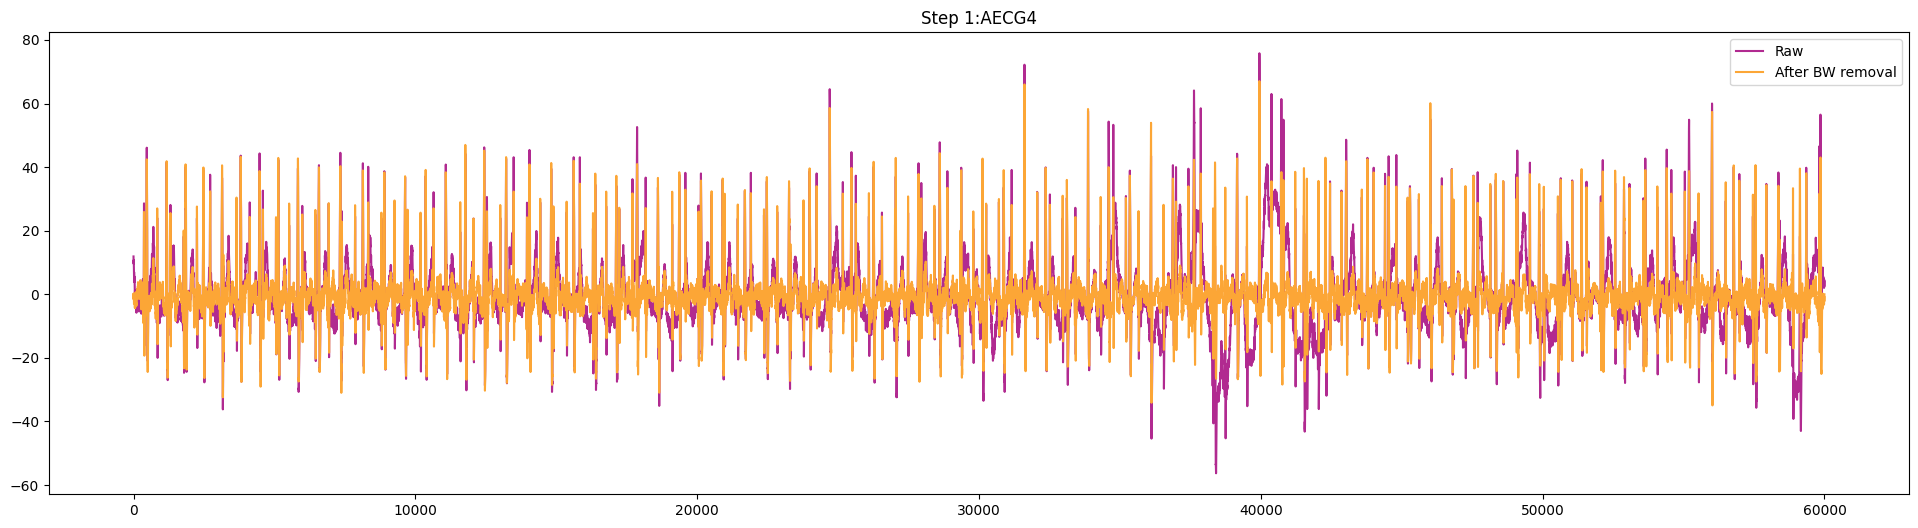

In [7]:
utils.initial_plot(X,S2)

# STEP2: S2 → S3 — Power-line interference canceller

An Adaptive Noise Cancelling (ANC) technique is applied, based on the Martens method, to eliminate the power-line interference (e.g., $50 \text{ Hz}$) and its higher-order harmonics. The method iteratively estimates and adapts the amplitude, phase, and frequency of the interference in each channel before subtraction, ensuring robust removal even with line frequency fluctuations.

In [8]:
S3 = powerline_interference_canceller(S2, fs)

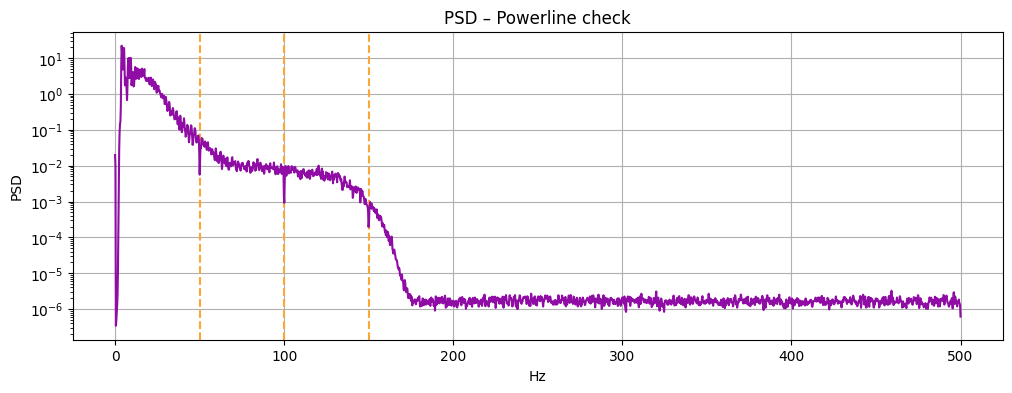

In [9]:
utils.plot_power(S2,fs)

In [10]:
n_channels = S2.shape[1]
removed_db = np.zeros(n_channels)

for ch in range(n_channels):
        E_removed = np.mean((S2[:, ch] - S3[:, ch])**2)
        E_signal  = np.mean(S2[:, ch]**2)
        removed_db[ch] = 10 * np.log10(E_removed / E_signal)

print("Removed energy per channel (dB): ", np.round(removed_db,2))

Removed energy per channel (dB):  [-37.63 -39.65 -40.45 -39.34]


# STEP 3: S3 → S4 — Upsampling a 2000 Hz 

The data is upsampled from $1000 \text{ Hz}$ to $2000 \text{ Hz}$. This higher sampling rate is necessary to achieve sufficient temporal resolution for effective template matching and subsequent MECG cancellation without leaving significant maternal residuals.

In [11]:
S4, fs_up = upsample_to_2kHz(S3, fs)

print("Old fs:", fs)
print("New fs:", fs_up)
print("Shape before:", S3.shape)
print("Shape after:", S4.shape)

Old fs: 1000
New fs: 2000
Shape before: (60000, 4)
Shape after: (120000, 4)


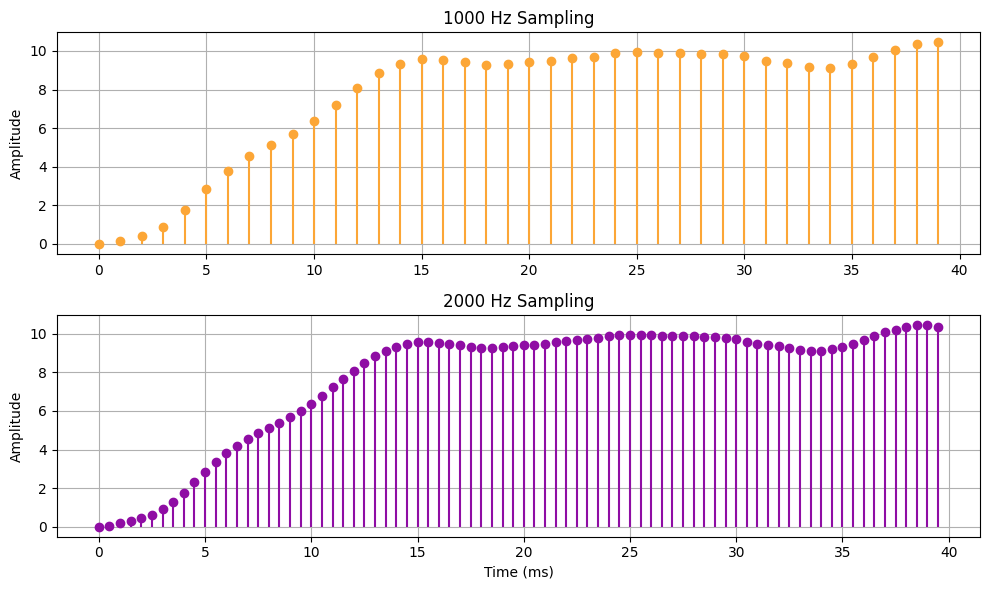

In [12]:
function.plot_sampling_comparison(S3, S4, fs, fs_up, ch=0, t_ms=40)

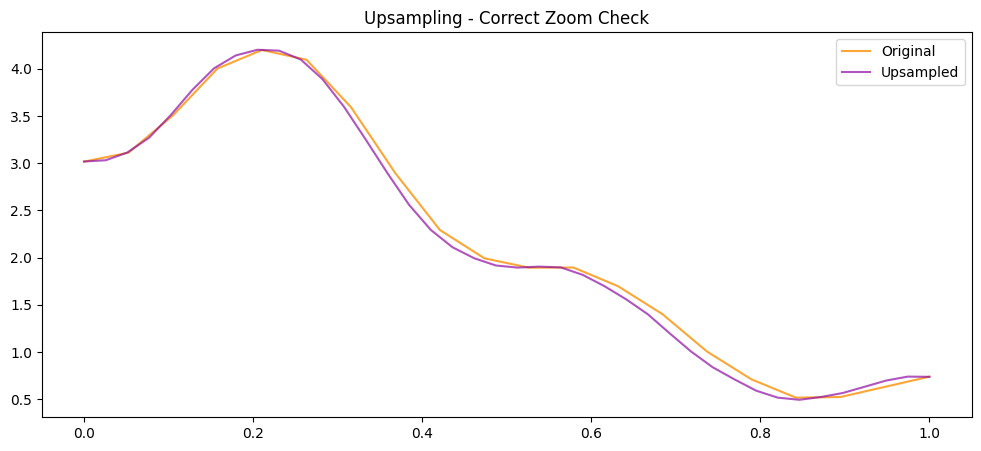

In [13]:
utils.plot_check_zoom(S3,S4, fs_up, fs)


# STEP 4: Maternal QRS detection

The maternal QRS detector follows the multi-stage processing scheme described by Martens (2007), combining PCA-based multi-channel enhancement with template-based cross-correlation. The algorithm operates in four steps:
1. **PCA-based multi-channel enhancement**: All abdominal channels in $S_4$ are variance-normalized and combined via PCA. The first principal component (PC1), which maximizes ECG-related variance.
2. **Rough QRS detection using a synthetic template**: A generic QRS template is cross-correlated with PC1 to highlight maternal QRS complexes.
Candidate peaks are identified using an adaptive percentile threshold, followed by a **$300 ms$** refractory period to suppress physiologically implausible double detections, and a ±40 ms refinement window to localize each R-peak precisely.
3. **Construction of a real maternal QRS template**: Short ECG segments **($±50 ms$)** around the rough detections are extracted and averaged to form a real maternal QRS template, capturing the true morphology of the maternal heart activity.
4. **Final detection using the real template**: PC1 is cross-correlated again using the real maternal template, performing a second matched filtering step.
Adaptive thresholding, a **300** ms refractory period, and a **±40 ms peak-refinement** window are applied to obtain accurate and stable maternal R-peak detections.

In [14]:
mQRS_clean, PC1_maternal_clean, corr_maternal_clean, maternal_template_clean = detect_mQRS(S4, fs_up)
print("Detected maternal QRS:", len(mQRS_clean))


Detected maternal QRS: 80


>**Adaptive thresholding**
>
>Added to handle amplitude variations and non-stationary noise. A global threshold can miss weak QRS or be distorted by artifacts, >while a local percentile-based threshold adapts to the signal and improves robustness.

>**Peak refinement**
>
>Introduced to correct small timing shifts caused by noise or template mismatch. Refining the peak within ±40 ms improves >alignment and reduces jitter and false detections.

## Plot Analysis

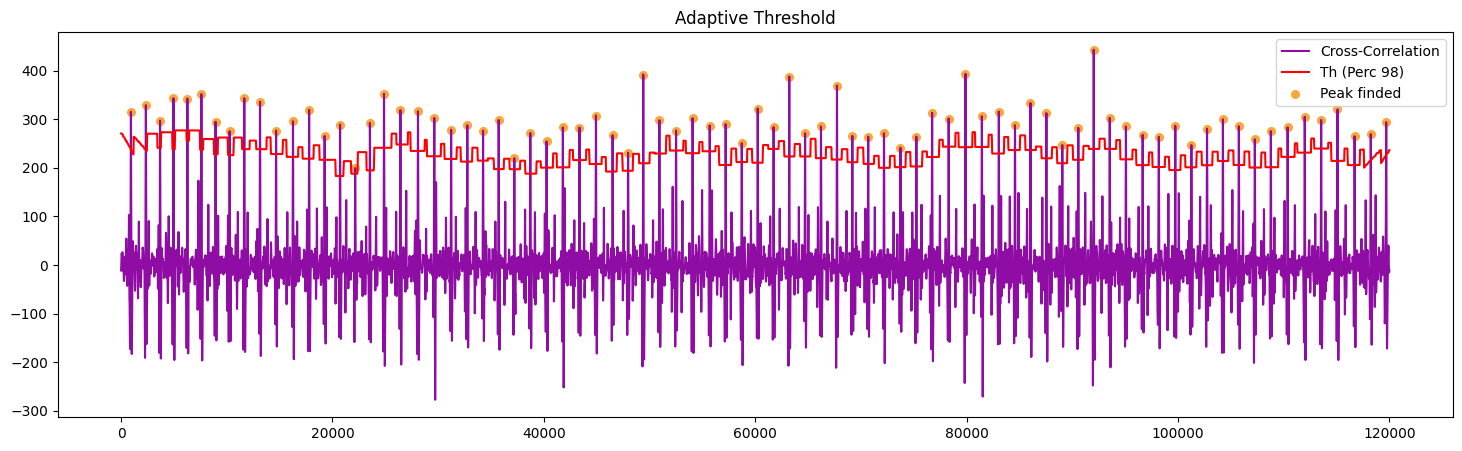

In [15]:
thr_98 = qrsdetection.adaptive_threshold(corr_maternal_clean, window=5000, perc=98)

plt.figure(figsize=(18, 5))
plt.plot(corr_maternal_clean, label="Cross-Correlation", color = colors[1])
plt.plot(thr_98, label="Th (Perc 98)", color='red')
plt.scatter(mQRS_clean, corr_maternal_clean[mQRS_clean], color=colors[0], marker='o', s=30, label="Peak finded")
plt.title("Adaptive Threshold")
plt.legend()


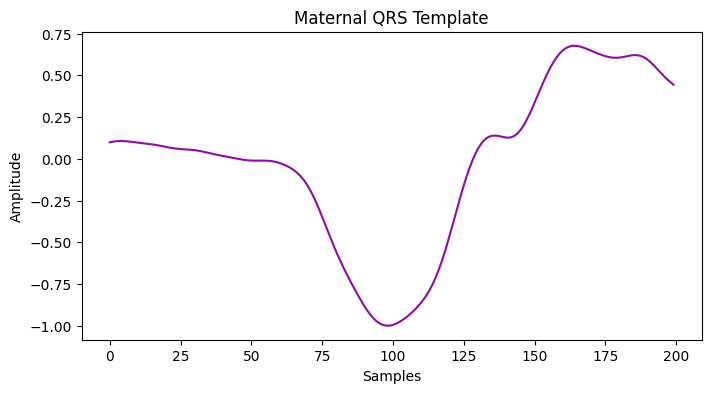

In [47]:
utils.plot_template_m(maternal_template_clean)

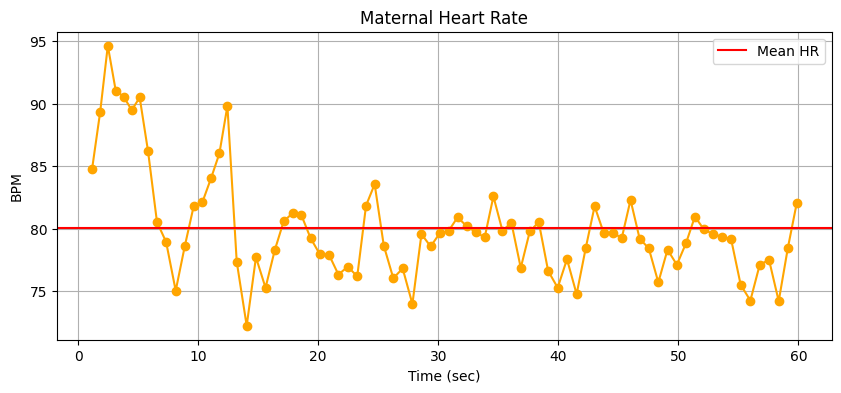

In [16]:
RR_seconds = np.diff(mQRS_clean) / fs_up
HR = 60 / RR_seconds

utils.plot_hrf(mQRS_clean, fs_up, HR, "Maternal")


In [17]:
print("Number of QRS detected:", len(mQRS_clean))
print("Mean RR (s):", np.mean(RR_seconds))
print("Min RR (s):", np.min(RR_seconds))
print("Max RR (s):", np.max(RR_seconds))
print("HR mean (bpm):", np.mean(HR))
print("HR std (bpm):", np.std(HR))


Number of QRS detected: 80
Mean RR (s): 0.7517784810126582
Min RR (s): 0.634
Max RR (s): 0.8305
HR mean (bpm): 80.0268213855945
HR std (bpm): 4.285923167392441


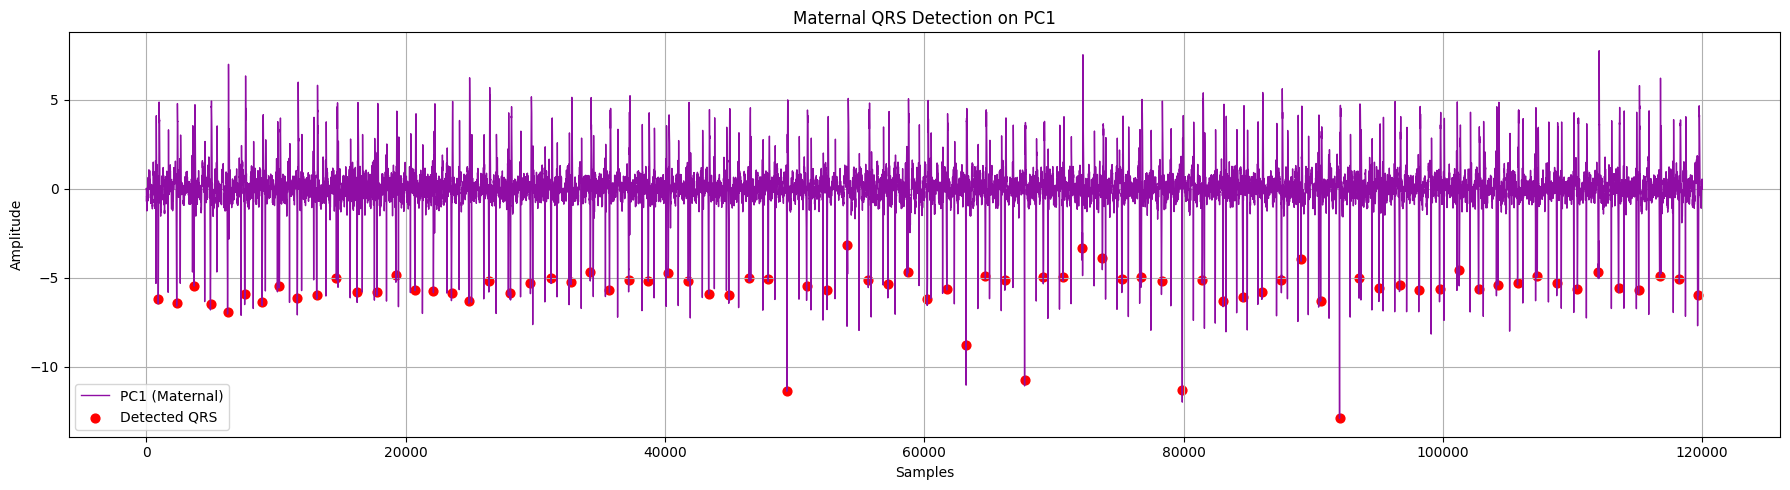

In [18]:
utils.plot_qrs_det_m(PC1_maternal_clean,mQRS_clean)

# STEP 5: S5 - MECG - Canceller

The objective of this function is to estimate and subtract the maternal ECG complex from each channel, using an adaptive version of template subtraction divided into three parts: P-wave, QRS, and T-wave, each scaled independently.

1. **Window**, for each maternal beat identified in mQRS, a window is taken:
- P-wave: −250 ms → −50 ms
- QRS: −50 ms → +50 ms
- T-wave: +50 ms → +450 ms

Total length: 1400 samples.

2. **Template**, for each current QRS, the last N maternal beats are selected and the average template is calculated:
$$
    \mu(t) = \frac{1}{N} \sum_{i=1}^{N} m_i(t)
$$
where $𝑚_𝑖(𝑡)$ is the segment around the previous QRS complexes.

3. **Energy Normalization**, before estimating the scale coefficients, the *template and current window are normalized*:
$$
    \mu_n = \frac{\mu}{\sigma_\mu} , m_n = \frac{m}{\sigma_m}  
$$
This is done to make the segments comparable and avoid dependence on amplitude.

4. **Template division**:
- $\mu_P$
- $\mu_{QRS}$
- $\mu_T$

5. **Matrix Construction**:
$$
    M =
    \begin{bmatrix}
    \mu_P & 0      & 0 \\
    0     & \mu_{QRS} & 0 \\
    0     & 0      & \mu_T
    \end{bmatrix}
$$

6. **Scale coefficient** estimation, estimate the vector of scaling coefficients:
$$
    a = 
    \begin{bmatrix}
    a_P \\
    a_{QRS} \\
    a_T
    \end{bmatrix}
$$
such that the normalized segment $m_n$ is approximated by the template matrix $M$:
$$
    m_n \approx M\,a
$$
The optimal coefficients are obtained using the pseudoinverse:
$$
    a = M^{\dagger} \, m_n
$$

7. **Reconstruction** of the **estimated MECG**, the estimated normalized MECG segment is reconstructed as:
$$
\hat{m}_n = M\,a
$$
Then it is rescaled back to the original amplitude:
$$
\hat{m} = \hat{m}_n \cdot \sigma_m
$$
8. **Subtraction** from the signal, the estimated maternal component is removed from the abdominal channel:
$$
    S(t) = S(t) - \hat{m}(t)
$$


This operation is applied for every channel and every detected maternal QRS.

**Iteration**
The cancellation process is typically repeated 3 times, so that each pass refines the MECG estimate and further reduces residual maternal interference.

In [19]:
S4_pre = S4.copy()
# iterative MECG cancellation
for i in range(3):
    S4 = mecg_canceller(S4, mQRS_clean, fs_up, N=30)

S5 = S4

In [20]:
S4 = S4_pre

## Plot Analysis

In [21]:
utils.check_variance_reduction(S4, S5)

Total Variance Reduced: 66.11%


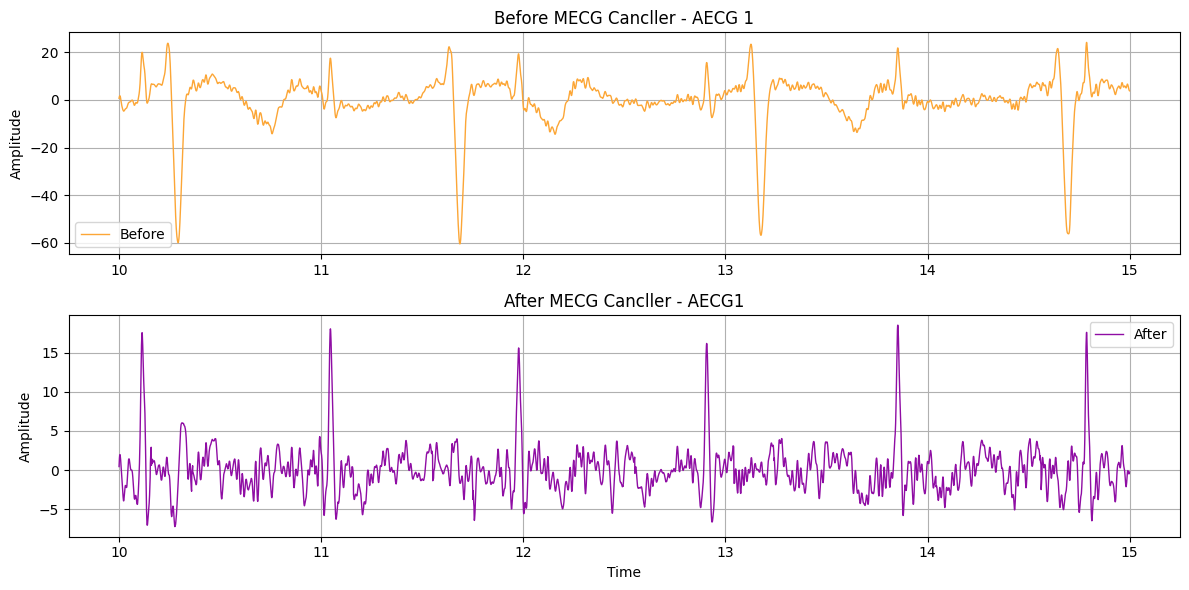

In [22]:
utils.plot_before_after(S4,S5,fs, 'MECG Cancller')

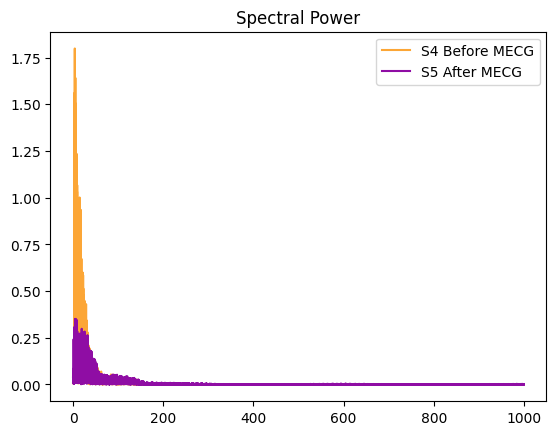

In [23]:
utils.plot_spectral_density_power(S4_pre,fs_up,S5)

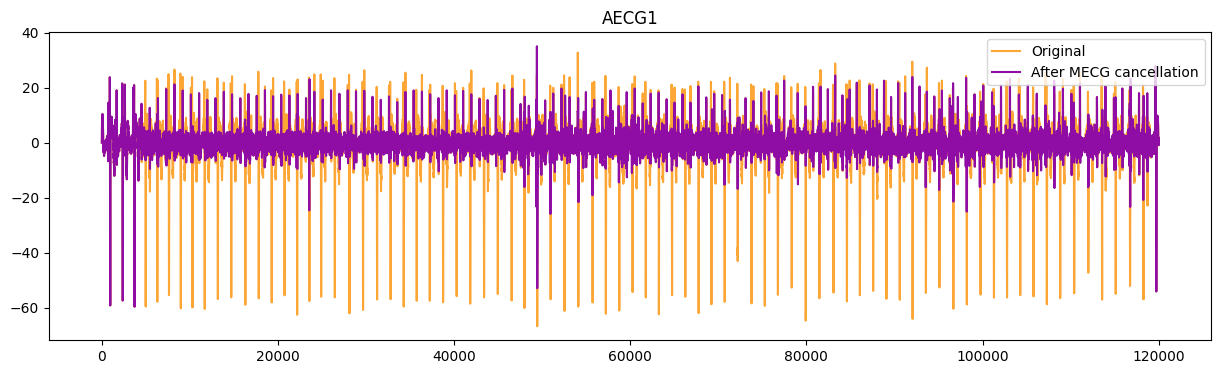

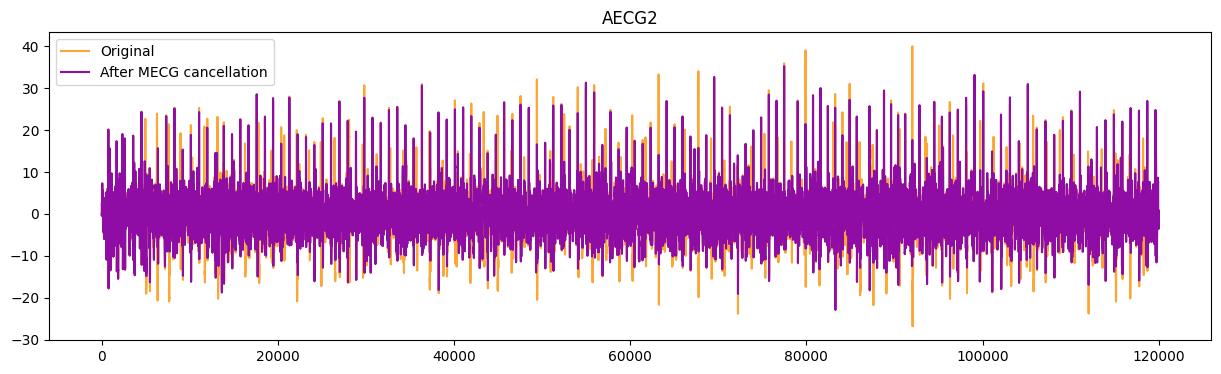

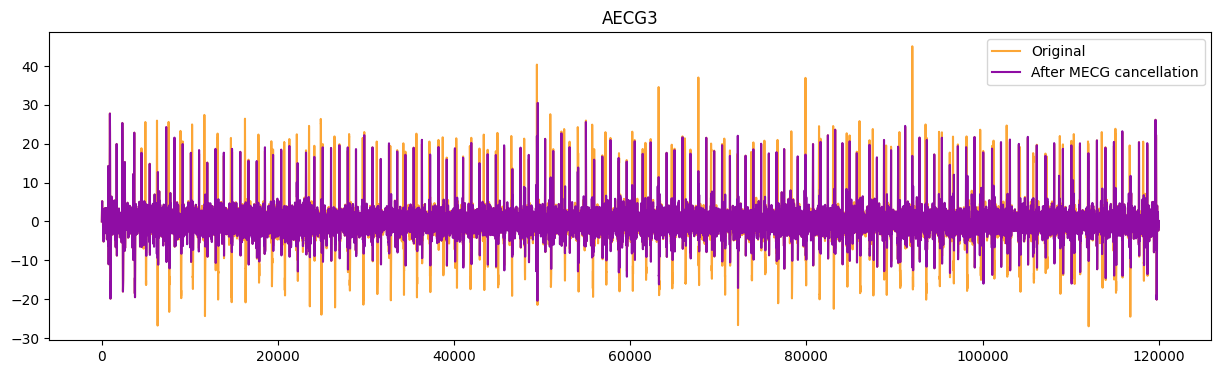

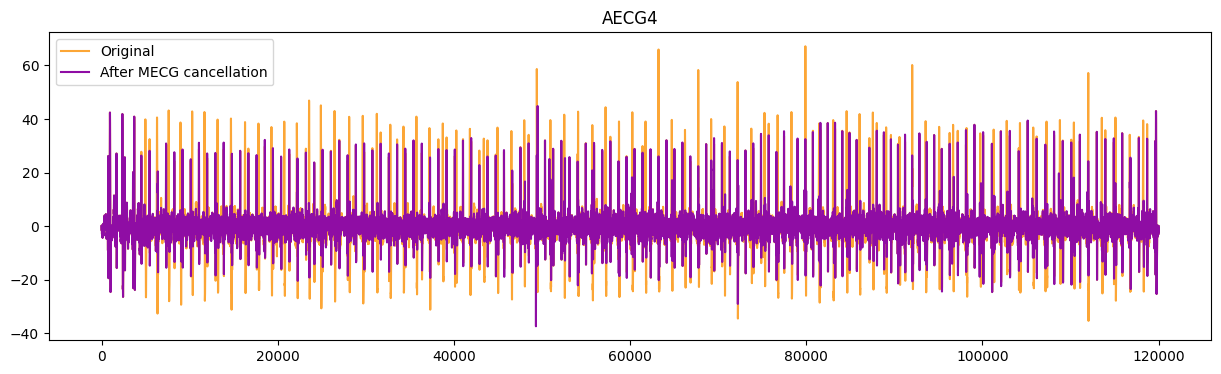

In [24]:
utils.plot_reduction_on_ch(S4,S5)
    

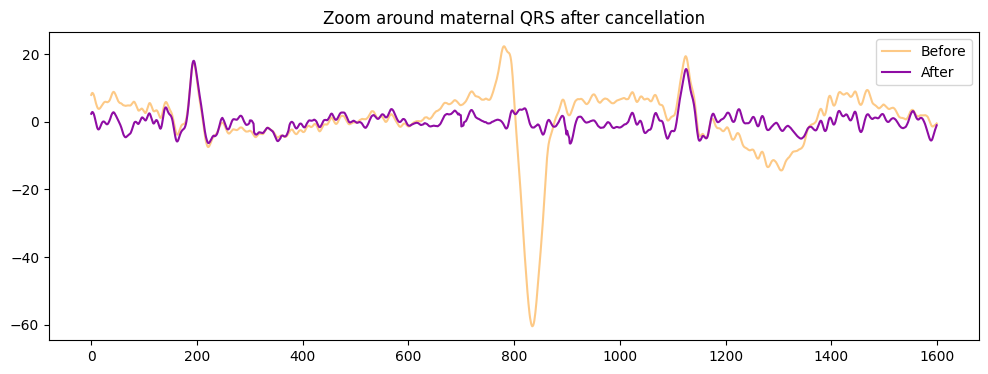

In [25]:
utils.plot_single_after_MECG_canc(mQRS_clean, S4_pre, S5)


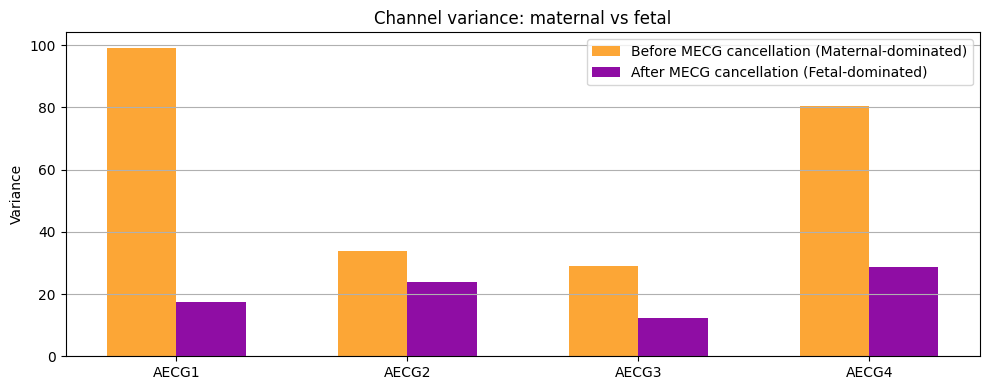

In [26]:
utils.plot_ch_var(S4_pre,S5)

# STEP 6: Fetal QRS Detection

This function applies the same detection logic used for maternal QRS detection, but with parameters adapted to fetal physiology.
1. **PCA**: All abdominal channels in $S_5$ are variance-normalized and combined via PCA. The first principal component (PC1), which maximizes ECG-related variance.
2. **Rough detection with synthetic template**: Cross-correlation is applied with a synthetic fetal template (narrow and morphology-agnostic).
Peaks are extracted using an adaptive threshold and reduced refractory period (0.15 s).
3. **Construction of the real fetal template**: Short windows (±20 ms) are extracted around the preliminary peaks, which, when averaged, produce a real fetal QRS template (subject-specific matched filtering).
4. **Final detection**: Cross-correlation is repeated using the real template, obtaining a more accurate detection with a reduced refinement window (±20 ms).


In [27]:
clean_fQRS, PC1_f, corr_f, tmpl_f = detect_fQRS(S5, fs_up )
print("Fetal QRS detected:", len(clean_fQRS))

Fetal QRS detected: 129


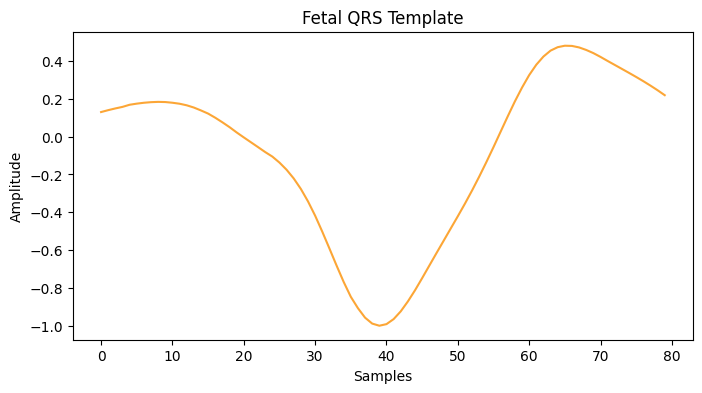

In [28]:
utils.plot_template_f(tmpl_f)

In [29]:
def compute_FHR(fQRS, fs_up):
    fQRS = np.array(fQRS)
    RR = np.diff(fQRS) / fs_up  # sec
    FHR = 60 / RR               # bpm
    return FHR

FHR = compute_FHR(clean_fQRS, fs_up)
print("Fetal: ",np.mean(FHR).round(2), "bpm")

FHR = compute_FHR(mQRS_clean, fs_up)
print("Mum:",np.mean(FHR).round(2),"bpm")

Fetal:  130.21 bpm
Mum: 80.03 bpm


# STEP 7: S5 → S6 — FECG Detector


After fetal QRS detection, Martens constructs an **average fetal ECG complex** to increase the signal-to-noise ratio of the FECG.
The idea is: align many fetal beats and average them, so the coherent fetal components are reinforced while noise cancels out.

1. **Window** around each fetal QRS
2. **Select** the first **150 fetal** beats
$$
    N_{av}​=150
$$
3. **Extract aligned segments**
4. **Average** across all selected beats, the final FECG estimate in each channel is:
$$
    \hat{f}(t) = \frac{1}{N_{\text{av}}} \sum_{i=1}^{N_{\text{av}}} f_i(t)
$$


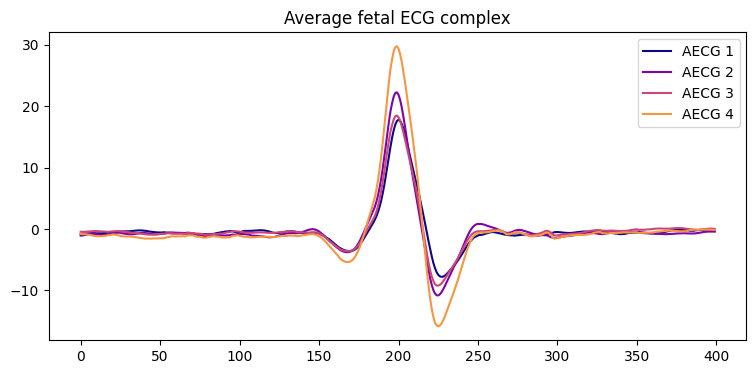

(400, 4)

In [30]:
S6 = FECG_avg(S5, clean_fQRS, fs_up)
S6.shape

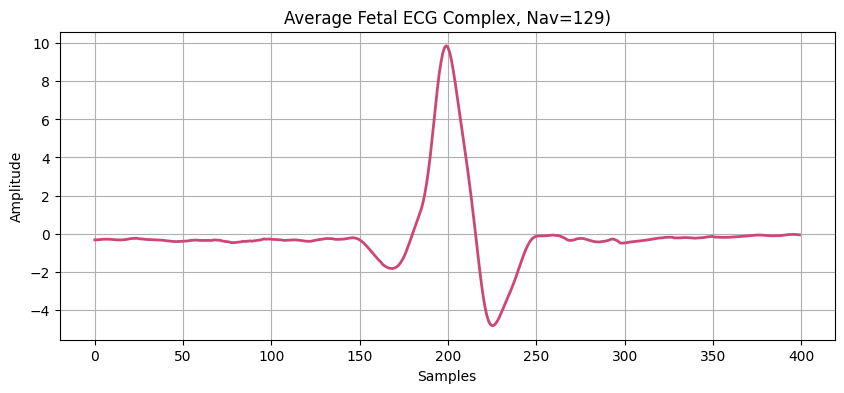

In [31]:
utils.plot_medium_S6(PC1_f, clean_fQRS, fs_up)

# Plot Analysis

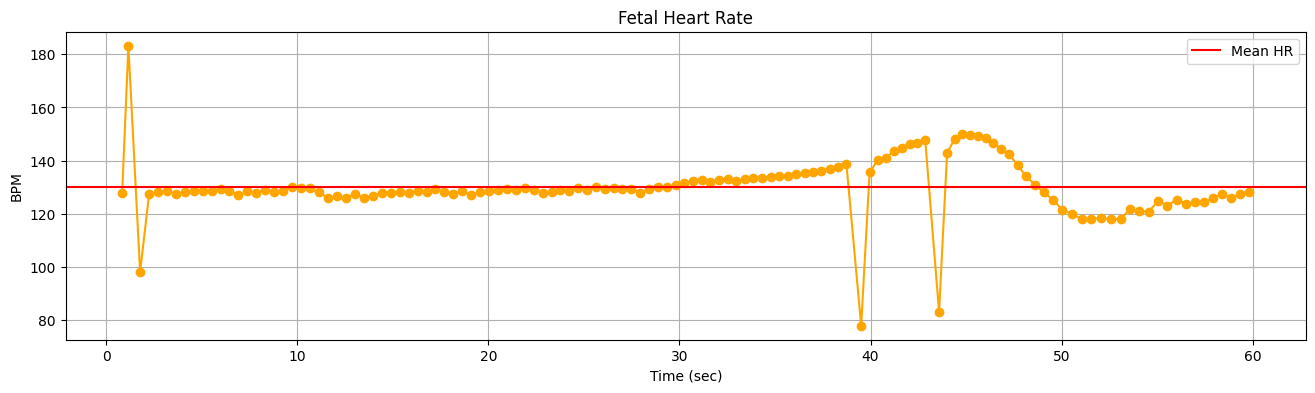

In [48]:
RR = np.diff(clean_fQRS) / fs_up
HR = 60 / RR
utils.plot_hrf(clean_fQRS, fs_up, HR, "Fetal")

In [33]:
print("Number of QRS detected:", len(clean_fQRS))
print("Mean RR (s):", np.mean(RR))
print("Min RR (s):", np.min(RR))
print("Max RR (s):", np.max(RR))
print("HR mean (bpm):", np.mean(HR))
print("HR std (bpm):", np.std(HR))


Number of QRS detected: 129
Mean RR (s): 0.46445703125
Min RR (s): 0.3275
Max RR (s): 0.7695
HR mean (bpm): 130.2104378557717
HR std (bpm): 10.82502535710286


# STEP 8: Evaluation Metrics

In [34]:
true_qrs_samples_up = (true_qrs * 2).astype(int)

## 8.1 Following Paper: SIR & SNR & Reliability

Fetal heart rate (FHR) is computed from successive fetal RR intervals.

Detection **reliability** is defined as one minus the ratio of outliers, where an outlier is an FHR value deviating more than 10 bpm from the local median within 10-second windows.

A detection is considered successful if the mean FHR is physiologically plausible and reliability exceeds 60%.

In [35]:
reliability, mean_bpm, is_successfull = calculate_paper_metrics(clean_fQRS, fs_up, S5.shape[0])
print("FHR Reliability:", reliability)
print("Mean FHR (bpm):", mean_bpm)
print("Is FHR Trace Successful?:", is_successfull)

FHR Reliability: 0.9453125
Mean FHR (bpm): 130.2104378557717
Is FHR Trace Successful?: True


**Signal-to-noise ratio** (SNR) and **signal-to-interference ratio** (SIR) are computed following Martens’ definitions.
- **Fetal ECG power** is estimated from the averaged fetal template (**S6**).
- **Noise power** is estimated as the residual signal after template subtraction (**S5 − S6**)
- **Maternal interference power** is estimated from the difference between pre- and post-cancellation signals (**S4 − S5**).

SNR and SIR are defined as the ratios between fetal signal power and noise or interference power, respectively.

In [36]:
SNR_dB, SIR_dB = compute_snr_sir_martens(S4_pre, S5, S6, clean_fQRS, fs_up)
print("SNR :", SNR_dB)
print("SIR :", SIR_dB)

SNR : 2.139987216037244
SIR : -1.5801107434503783


In [37]:
def compute_RR_from_peaks(fQRS, fs):
    fQRS = np.array(fQRS)
    RR_samples = np.diff(fQRS)
    RR_seconds = RR_samples / fs
    return RR_seconds

def compute_FHR(RR_seconds):
    return 60.0 / RR_seconds

RR = compute_RR_from_peaks(clean_fQRS, fs_up)
FHR = compute_FHR(RR)

In [38]:
def resample_FHR(FHR, fs_fhr=4):
    n = len(FHR)
    t_original = np.cumsum(np.ones(n))  
    t_original = t_original / 2        
    return FHR  
FHR = resample_FHR(FHR, fs_fhr=4)


## 8.2 Gold Standard Analysis: fQRS real

In [39]:
metrics = compute_metrics(clean_fQRS,true_qrs_samples_up,fs_up)
print('SE: ', metrics['SE'])
print('PPV: ', metrics['PPV'])
print('F1: ', metrics['F1'])
print('TP: ', metrics['TP'])
print('FP: ', metrics['FP'])
print('FN: ', metrics['FN'])
print('ACC: ', metrics['ACC'])


SE:  0.9922
PPV:  0.9922
F1:  0.9922
TP:  128
FP:  1
FN:  1
ACC:  0.9846


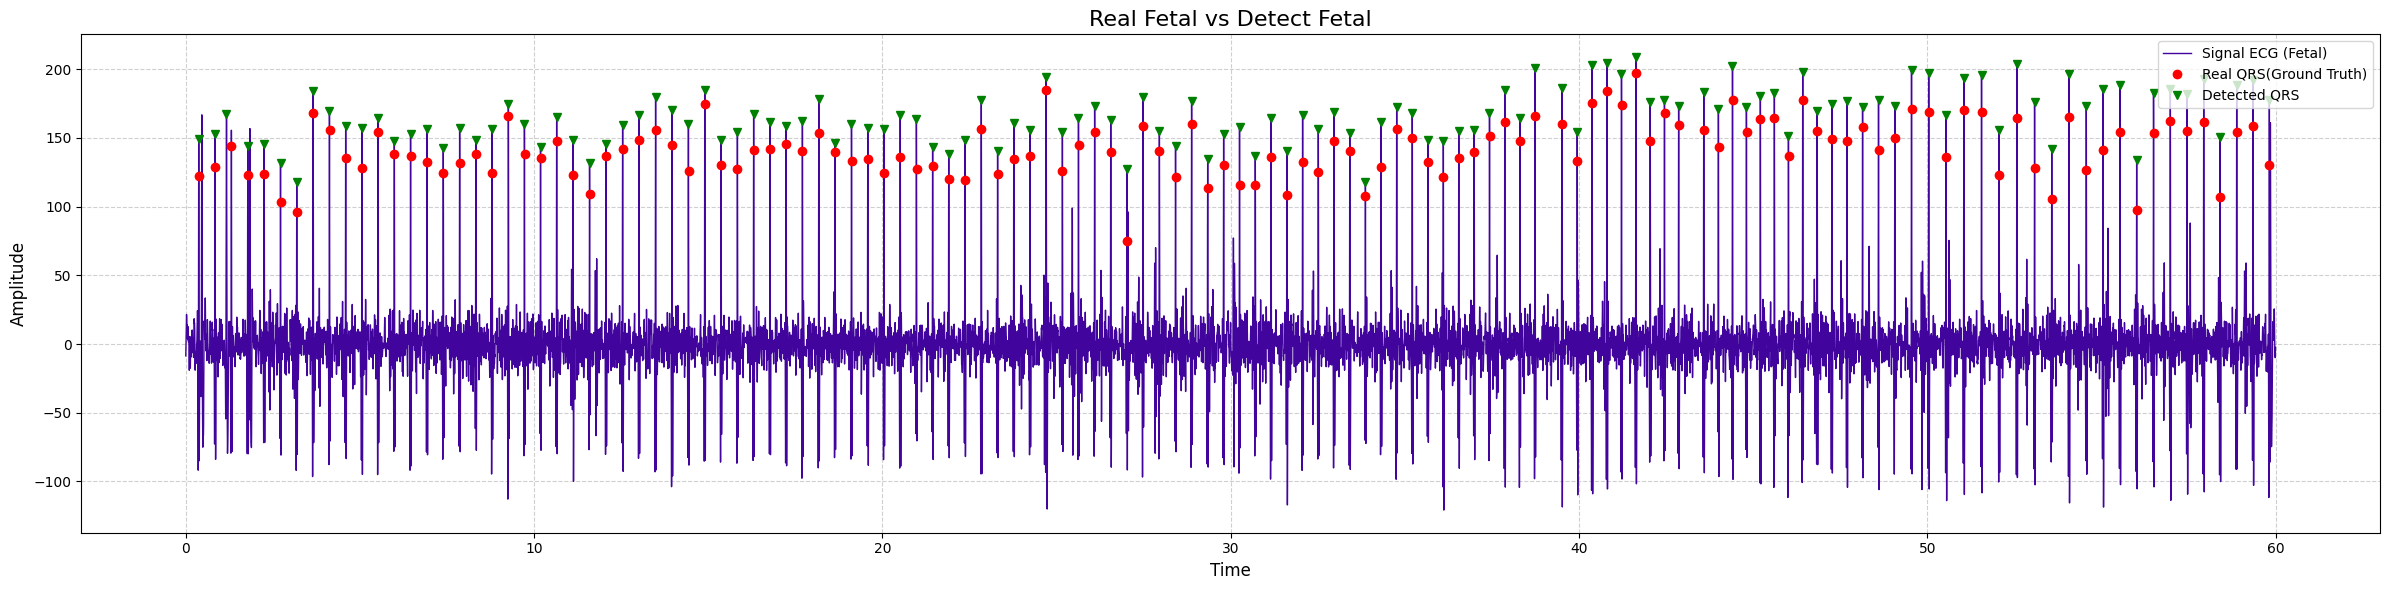

In [40]:
utils.plot_qrs_comparison(corr_f, true_qrs_samples_up, clean_fQRS, fs_up)


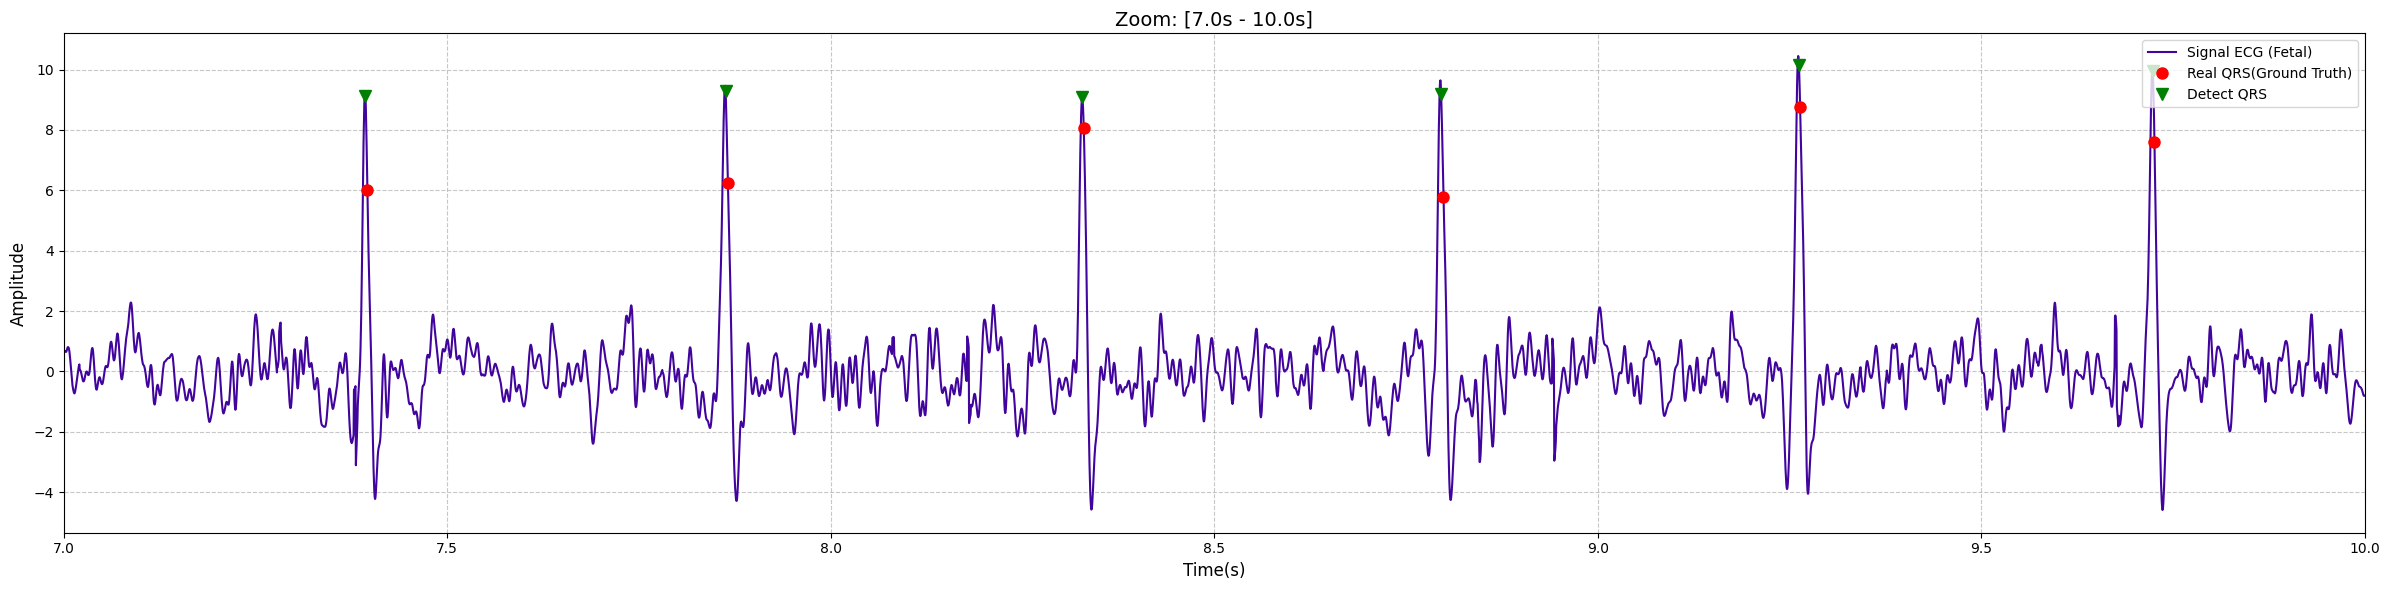

In [41]:
start_time = 7.0 
duration = 3

utils.plot_qrs_zoom(
    ecg_signal=-PC1_f, 
    true_qrs=true_qrs_samples_up, 
    detected_qrs=clean_fQRS, 
    fs=fs_up,
    start_time_sec=start_time,
    duration_sec=duration
)

# Final Plot

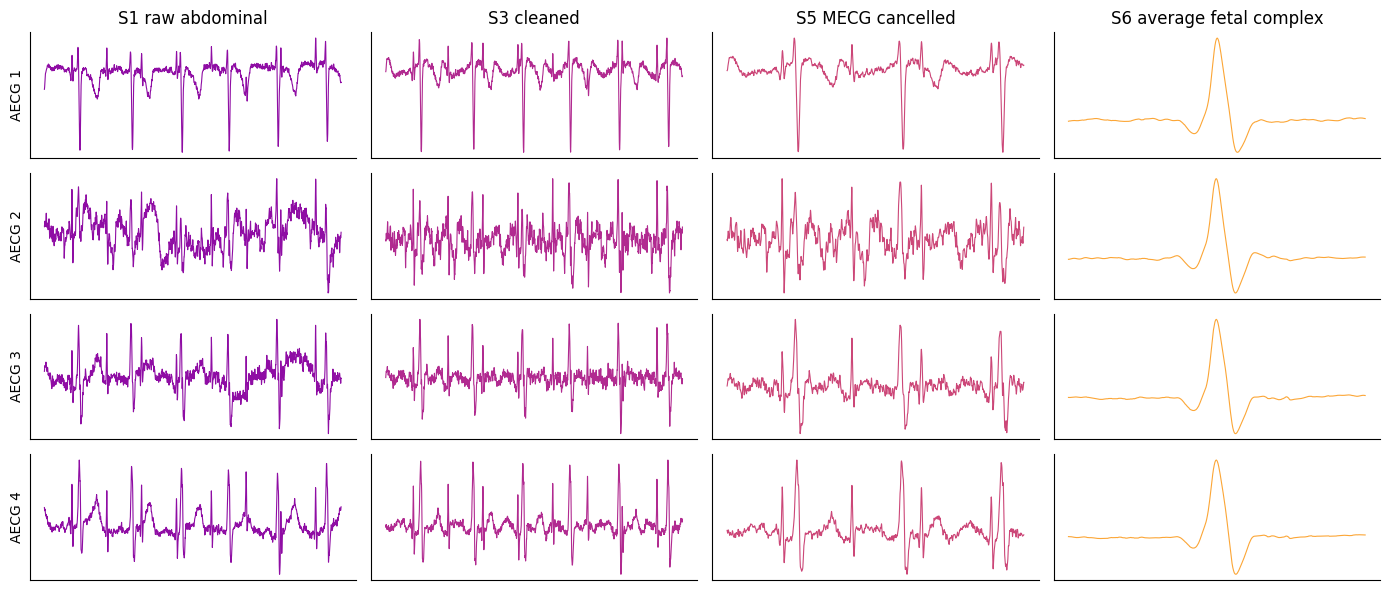

In [42]:
utils.final_plot_comparison(X,fs_up,S3,S5,S6)

# Statistical Analysis on all Dataset

The analysis shows a clear **positive correlation** between abdominal signal quality (SNR and SIR) and the reliability of fetal QRS detection.
At very low SNR and SIR values, reliability is generally poor, indicating that the fetal ECG is strongly affected by noise and residual maternal components.

As SNR and SIR increase, detection **reliability improves progressively**, reaching values above **80–90%** for sufficiently good signal conditions.

These results indicate that the performance of the proposed algorithm is strongly influenced by the signal quality after MECG cancellation, in agreement with the findings reported by Martens et al.
Under favorable conditions, the implemented pipeline is able to provide highly reliable fetal QRS detection.

In [43]:
df = pd.read_csv("./result/A_RESULT.csv")

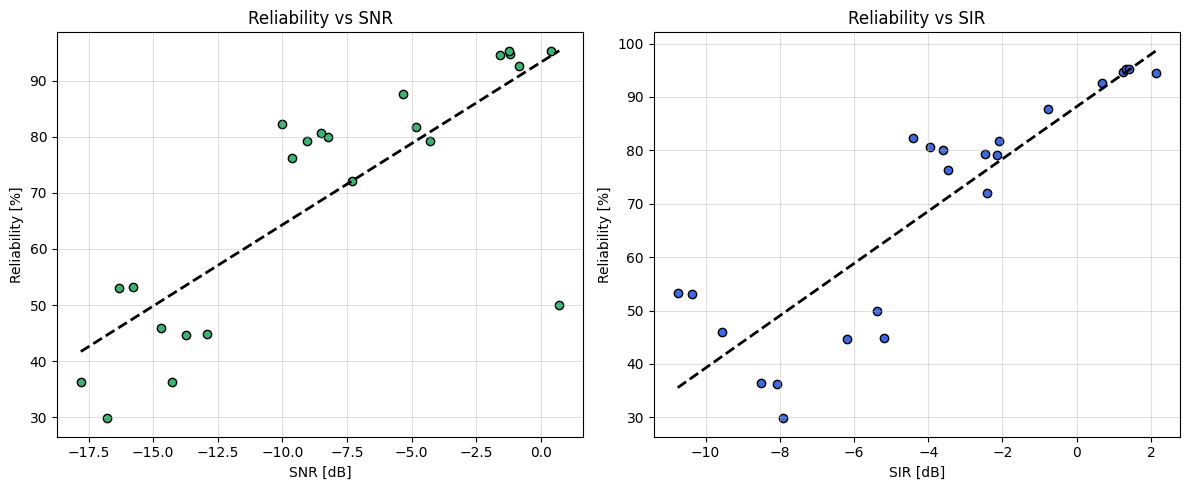

In [44]:
function.plot_reliability_vs_snr_sir(df)

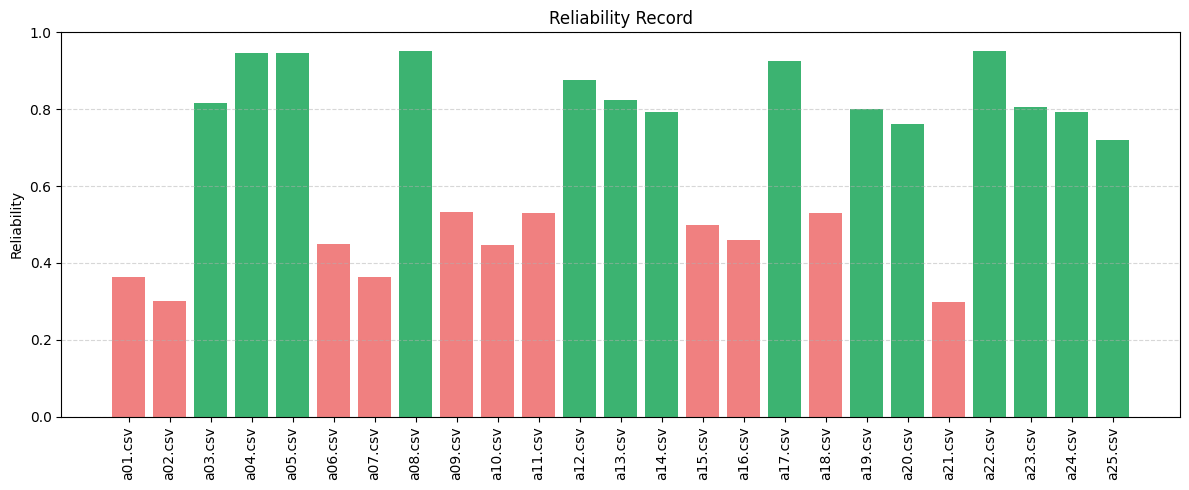

In [45]:
function.plot_reliability_all(df)

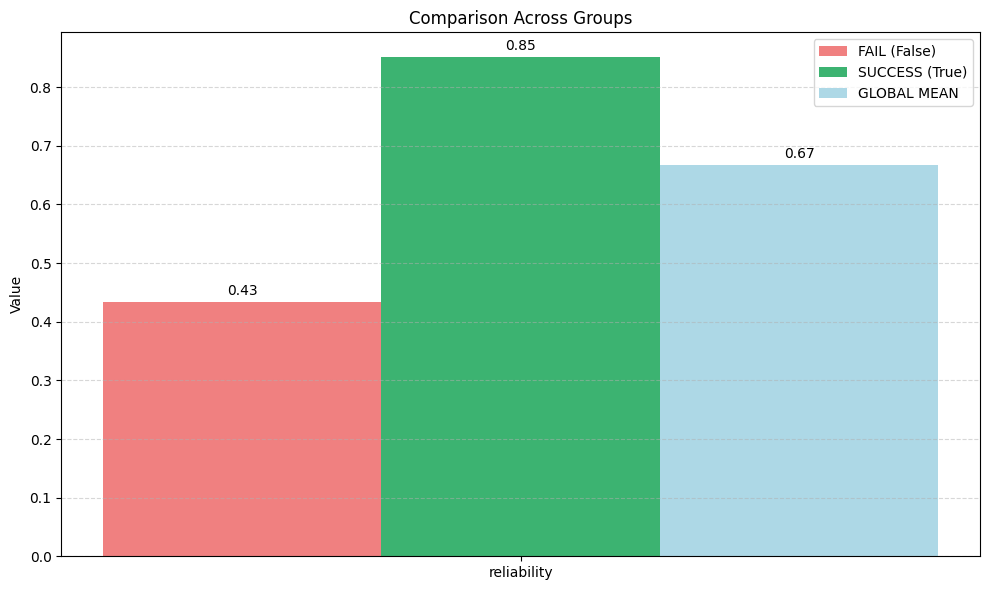

In [46]:
function.plot_all_metrics_groups(df, ['reliability'])